# Qwen3 Tuning
for ARC AGI 2

In [1]:
# ---------------------------------------------------------------------
# Config (loaded from YAML with environment variable overrides)
# ---------------------------------------------------------------------
import yaml
import os
import argparse
import sys
from pathlib import Path

def load_config_from_yaml(config_path="config.yaml"):
  """Load configuration from YAML file with environment variable overrides."""
  if not Path(config_path).exists():
      print(f"Config file {config_path} not found! Using default values.")
      return {}

  with open(config_path, 'r') as f:
      config = yaml.safe_load(f)

  print(f"✅ Loaded config from: {config_path}")
  return config

# Detect if we're running as script vs notebook and handle config path accordingly
if '__file__' in globals():
    # Script mode - use argparse for --config parameter
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', default='config.yaml', help='Path to config file')
    args, unknown = parser.parse_known_args()
    config_path = args.config
else:
    # Notebook mode - use default config file
    config_path = "config.yaml"

# Load configuration
config = load_config_from_yaml(config_path)

# Extract values with fallbacks and environment variable overrides
test_run = config.get('test_run', False)
is_kaggle = config.get('is_kaggle', False)

# Override if running on Kaggle
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is not None:
    is_kaggle = True

# Environment variable overrides
model_save_dir = os.environ.get('MODEL_SAVE_DIR', 
                              os.environ.get('LOCAL_MODEL_DIR',
                                            config.get('model_save_dir', "/kaggle/working/")))

execution_mode = os.environ.get('FINE_TUNING_MODE', config.get('execution_mode', 'full'))

# Data source configuration
data_config = config.get('data', {})
data_source = os.environ.get('DATA_SOURCE', data_config.get('source', 'huggingface'))
parquet_path = os.environ.get('ARC_PROGRAMS_PARQUET',
                              data_config.get('parquet', {}).get('path', '../datasets/inference/'))

# Dataset configuration
train_slug = data_config.get('dataset_slug', None)
if data_source == 'parquet' or train_slug is None:
    data_source = 'parquet'  # Default to parquet now
    train_slug = None
    print(f"📊 Data source: parquet ({parquet_path})")
else:
    print(f"📊 Data source: huggingface ({train_slug})")

# Model configuration with environment override
model_config = config.get('model', {})
model_slug = os.environ.get('MODEL_SLUG', model_config.get('slug', "Qwen/Qwen3-4B"))
model_max_length = model_config.get('max_length', 32768)
lora_rank = model_config.get('lora_rank', 128)

# Training configuration
training_config = config.get('training', {})
batch_size_global = 1 if is_kaggle else training_config.get('batch_size_global', 4)
enable_thinking = training_config.get('enable_thinking', False)

# Handle max_rows with test_run override
if test_run:
  overrides = config.get('overrides', {})
  max_rows = overrides.get('test_run_max_rows', 128)
else:
  max_rows = training_config.get('max_rows')  # None for all rows

# Print loaded configuration
print(f"Config loaded:")
print(f"  config_path: {config_path}")
print(f"  test_run: {test_run}")
print(f"  execution_mode: {execution_mode}")
print(f"  data_source: {data_source}")
print(f"  model_slug: {model_slug}")
print(f"  batch_size_global: {batch_size_global}")
print(f"  max_rows: {max_rows}")
print(f"  model_save_dir: {model_save_dir}")
if train_slug:
    print(f"  train_slug: {train_slug}")
else:
    print(f"  parquet_path: {parquet_path}")
print("-" * 50)

✅ Loaded config from: config.yaml
📊 Data source: parquet (../datasets/rewritten/)
Config loaded:
  config_path: config.yaml
  test_run: False
  execution_mode: full
  data_source: parquet
  model_slug: Qwen/Qwen3-4B
  batch_size_global: 4
  max_rows: None
  model_save_dir: /workspace/arc-agi-2025/llm_python/fine-tuning/merged
  parquet_path: ../datasets/rewritten/
--------------------------------------------------


In [2]:
# Check if env variable exists
if is_kaggle:
    report_to = "none"
else:
    report_to = ["wandb"]

print(f"Report to: {report_to}")

Report to: ['wandb']


In [3]:
if not config.get("training", {}).get("multi_gpu", False):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # single GPU

if not is_kaggle:
    os.environ["HF_HOME"] = "/workspace"
    os.environ["HF_HUB_CACHE"] = "/workspace/hub" # (recommended) override just the repo cache
    os.environ["TRANSFORMERS_CACHE"] = "/workspace/transformers"

### Installation

In [4]:
from huggingface_hub import HfFolder, login

if not is_kaggle:
    # Call this at the top of your script / notebook
    if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
        login()                        # interactive prompt

/workspace/arc-agi-2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Unsloth

In [5]:
import unsloth
import os
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = model_max_length,   # Context length - can be longer, but uses more memory
    # load_in_4bit = False,     # 4bit uses much less memory
    # load_in_8bit = False,    # A bit more accurate, uses 2x memory
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/workspace/arc-agi-2025/.venv/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


🦥 Unsloth Zoo will now patch everything to make training faster!


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.9: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA H200. Num GPUs = 1. Max memory: 139.719 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 9.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [6]:
print(f"model.max_seq_length: {model.max_seq_length}")

model.max_seq_length: 32768


In [7]:
# # Print a summary of the transformer layers and key dimensions
# for i, block in enumerate(model.model.layers):
#     attn = block.self_attn
#     mlp = block.mlp

#     print(f"Layer {i}:")
#     print(f"  Attention:")
#     print(f"    q_proj: {attn.q_proj.weight.shape}")
#     print(f"    k_proj: {attn.k_proj.weight.shape}")
#     print(f"    v_proj: {attn.v_proj.weight.shape}")
#     print(f"    out_proj: {attn.o_proj.weight.shape}")
#     print(f"  MLP:")
#     print(f"    fc1: {mlp.gate_proj.weight.shape}")
#     print(f"    fc2: {mlp.up_proj.weight.shape}")
#     print(f"    fc3: {mlp.down_proj.weight.shape}")
#     print()

In [8]:
# print(model)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [9]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128. could consider 128.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                     ],
    lora_alpha = 64,  # Best to choose alpha = rank or rank*2. EXCEPT if using rslora, in which case set it as sqrt(max matrix dimension). 64 is good for Qwen 4B
    lora_dropout = 0.05, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    # use_gradient_checkpointing = False, # Hard to know if this really turns it off.
    random_state = 3407,
    use_rslora = True,   # We support rank stabilized LoRA
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.8.9 patched 36 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [10]:
# %%
print(f"tokenizer.padding_side: {tokenizer.padding_side}")
# %%

tokenizer.padding_side: right


In [11]:
# Import utils using standard project root detection
from pathlib import Path
import sys

if not is_kaggle:
    # Find project root by looking for pyproject.toml
    project_root = next(
      (parent for parent in [Path.cwd()] + list(Path.cwd().parents)
       if (parent / "pyproject.toml").exists()),
      Path.cwd()
    )
    
    # Add project root to path for consistent imports
    sys.path.insert(0, str(project_root))
    
    print(f"📁 Project root: {project_root}")

# Import from llm_python with consistent root-level imports
from llm_python.utils.task_loader import TaskLoader
from llm_python.utils.scoring import GridScorer
from llm_python.utils.arc_tester import ArcTester
from llm_python.utils.prompt_utils import create_arc_prompt, extract_python_code
from llm_python.utils.metrics_utils import calculate_task_metrics, format_metrics_display, metrics_to_percentages
from llm_python.utils.timeout_utils import execute_with_timeout
from llm_python.utils.prompt_loader import PromptLoader

# Initialize utility instances
prompt_loader = PromptLoader()
scorer = GridScorer()
print("✅ Utils imported and initialized successfully")


📁 Project root: /workspace/arc-agi-2025
✅ Utils imported and initialized successfully


<a name="Data"></a>
### Data Prep

In [12]:
import re

def clean_multiple_newlines(code: str) -> str:
    """Remove multiple consecutive newlines and replace with at most one empty line."""
    # Pattern to match multiple consecutive newlines with optional whitespace
    # This handles cases like \n\n\n, \n  \n\n, \n\t\n\n\n etc.
    pattern = r'\n(\s*\n)+'
    # Replace with at most one empty line (two newlines)
    cleaned = re.sub(pattern, '\n\n', code)
    return cleaned

def count_tokens(text: str, tokenizer) -> int:
    """Count tokens in text using the provided tokenizer."""
    return len(tokenizer.encode(text))

def should_filter_code(code: str, tokenizer, max_tokens: int = 2000) -> bool:
    """Check if code should be filtered based on token count."""
    return count_tokens(code, tokenizer) > max_tokens

print("✅ Added code cleaning and filtering functions")


✅ Added code cleaning and filtering functions


In [13]:
# Test cases
test_code = """def solve(grid):
  # First comment


  # Second comment after multiple empty lines
  rows = len(grid)
  cols = len(grid[0])
  
  # Another comment
    
    
  return grid"""

print("ORIGINAL CODE:")
print(repr(test_code))
print("\nORIGINAL CODE (formatted):")
print(test_code)

cleaned = clean_multiple_newlines(test_code)
print("\n" + "="*50)
print("CLEANED CODE:")
print(repr(cleaned))
print("\nCLEANED CODE (formatted):")
print(cleaned)

print("\n" + "="*50)
print("CHANGES SUMMARY:")
print(f"Original length: {len(test_code)} chars")
print(f"Cleaned length: {len(cleaned)} chars")
print(f"Characters removed: {len(test_code) - len(cleaned)}")

ORIGINAL CODE:
'def solve(grid):\n  # First comment\n\n\n  # Second comment after multiple empty lines\n  rows = len(grid)\n  cols = len(grid[0])\n\n  # Another comment\n\n\n  return grid'

ORIGINAL CODE (formatted):
def solve(grid):
  # First comment


  # Second comment after multiple empty lines
  rows = len(grid)
  cols = len(grid[0])

  # Another comment


  return grid

CLEANED CODE:
'def solve(grid):\n  # First comment\n\n  # Second comment after multiple empty lines\n  rows = len(grid)\n  cols = len(grid[0])\n\n  # Another comment\n\n  return grid'

CLEANED CODE (formatted):
def solve(grid):
  # First comment

  # Second comment after multiple empty lines
  rows = len(grid)
  cols = len(grid[0])

  # Another comment

  return grid

CHANGES SUMMARY:
Original length: 160 chars
Cleaned length: 158 chars
Characters removed: 2


In [14]:
from datasets import load_dataset, DatasetDict

from llm_python.utils.task_loader import get_task_loader
from llm_python.datasets.parquet_utils import parquet_to_dataset

# Add this debug code right after building raw_ds:
if data_source == "parquet":
  raw_ds = parquet_to_dataset(parquet_path, max_rows)
  print("DEBUG: Available columns in dataset:", raw_ds.column_names)
  if len(raw_ds) > 0:
      print("DEBUG: First example keys:", raw_ds[0].keys())

SYSTEM_PROMPT = prompt_loader.get_system_message("soar")
INITIAL_TURN_PROMPT = prompt_loader.get_initial_turn_prompt("soar")

print(f"   System prompt: {len(SYSTEM_PROMPT)} chars")
print(f"   Initial turn prompt: {len(INITIAL_TURN_PROMPT)} chars")


def canonical_chat_mapper(example, task_loader, use_predicted_outputs=False):
    """
    Converts a raw example to canonical chat format.
    use_predicted_outputs: True for HF, False for parquet
    """
    task_id = example["task_id"]
    task_data = task_loader.get_task(task_id)

    raw_code = example["code"]
    cleaned_code = clean_multiple_newlines(raw_code)
    cleaned_flag = int(cleaned_code != raw_code)

    if use_predicted_outputs:
        train_outputs = example.get(
            "predicted_train_output",
            [ex["output"] for ex in task_data["train"]],
        )
        test_outputs = example.get(
            "predicted_test_output",
            [ex["output"] for ex in task_data["test"]],
        )
    else:
        train_outputs = [ex["output"] for ex in task_data["train"]]
        test_outputs = [ex["output"] for ex in task_data["test"]]

    task_data_for_prompt = {
        "train": [
            {"input": ex["input"], "output": out}
            for ex, out in zip(task_data["train"], train_outputs)
        ],
        "test": [
            {"input": ex["input"], "output": out}
            for ex, out in zip(task_data["test"], test_outputs)
        ],
    }

    code_original = example.get("code_original", "")
    predicted_train_output_original = example.get("predicted_train_output_original", [])

    # Generate either a refinement example or a non-refinement example depending on the row.
    system_content, user_content = (
        create_arc_prompt(
            task_data_for_prompt,
            prompt_loader,
            "soar",
            draft_program=code_original,
            predicted_outputs={ "train": predicted_train_output_original },
            output_mode="full",
        )
        if code_original
        else create_arc_prompt(task_data_for_prompt, prompt_loader, "soar")
    )

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content},
        {"role": "assistant", "content": f"```python\n{cleaned_code}\n```"},
    ]

    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False
    )
    prompt_text = tokenizer.apply_chat_template(
        messages[:-1],
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking,
    )

    return {
        "messages": messages,
        "text": text,
        "prompt": prompt_text,
        "train_input": [ex["input"] for ex in task_data_for_prompt["train"]],
        "train_output": train_outputs,
        "test_input": [ex["input"] for ex in task_data_for_prompt["test"]],
        "test_output": test_outputs,
        "task_id": task_id,
        "cleaned_newlines": cleaned_flag,
        "is_refinement_example": bool(code_original)
    }


def build_canonical_dataset(
    data_source, train_slug=None, parquet_path=None, max_rows=None, data_config=None
):
    """
    Build dataset from either HuggingFace or parquet source using canonical mapping.
    """
    task_loader = get_task_loader()
    use_predicted_outputs = data_source != "parquet"

    if data_source == "parquet":
        raw_ds = parquet_to_dataset(parquet_path, max_rows)
    else:
        effective_split = f"train[:{max_rows}]" if max_rows else "train"
        raw_ds = load_dataset(train_slug, split=effective_split)

    def keep_example(ex):
        try:
            task_loader.get_task(ex["task_id"])
        except FileNotFoundError:
            return False
        cleaned = clean_multiple_newlines(ex["code"])
        if should_filter_code(cleaned, tokenizer, max_tokens=2000):
            return False
        return True

    ds_kept = raw_ds.filter(keep_example, desc="pre-filter", load_from_cache_file=False)
    train_ds = ds_kept.map(
        lambda ex: canonical_chat_mapper(
            ex, task_loader, use_predicted_outputs=use_predicted_outputs
        ),
        desc="build chat fields",
        load_from_cache_file=False,
    )

    total_raw = raw_ds.num_rows
    kept = ds_kept.num_rows
    retained = train_ds.num_rows
    cleaned_count = (
        sum(train_ds["cleaned_newlines"])
        if "cleaned_newlines" in train_ds.column_names
        else 0
    )

    print("\n📊 Training data cleaning statistics:")
    print(f"   Total examples (raw slice): {total_raw}")
    print(f"   Removed in pre-filter: {total_raw - kept}")
    print(f"   Examples retained: {retained}")
    print(f"   Examples with cleaned newlines (retained): {cleaned_count}")
    print(f"   Examples with refinement: {sum(train_ds['is_refinement_example'])}")

    return DatasetDict(train=train_ds)
# ---------------------------------------------------------------------
# Build the dataset
# ---------------------------------------------------------------------
data = build_canonical_dataset(
    data_source=data_source,
    train_slug=train_slug,
    parquet_path=parquet_path,
    max_rows=max_rows,
    data_config=data_config,
)

from datasets import DatasetDict

# Calculate validation size: min(32, 10% of train set)
val_size = min(32, int(0.1 * len(data["train"])))

# Train/val split
train_size = len(data["train"]) - val_size
train_data = data["train"].select(range(train_size))
val_data = data["train"].select(range(train_size, len(data["train"])))

# Replace with new DatasetDict
data = DatasetDict({
    "train": train_data,
    "validation": val_data,
})

📊 Loading programs from parquet: ../datasets/rewritten/gpt-5-mini.parquet
✅ Loaded 712 rows from parquet
🔍 Filtered to 712 non-transductive programs (removed 0 transductive)
🔍 Selected 712 programs for fine-tuning
📦 Prepared 712 program records for fine-tuning
📈 Train success rate: 100.00%
📈 Test success rate: 100.00%
🤖 Models in dataset: openai/gpt-5-mini
DEBUG: Available columns in dataset: ['task_id', 'code', 'model', 'is_transductive', 'reasoning', 'correct_train_input', 'train_success', 'correct_test_input', 'test_success']
DEBUG: First example keys: dict_keys(['task_id', 'code', 'model', 'is_transductive', 'reasoning', 'correct_train_input', 'train_success', 'correct_test_input', 'test_success'])
   System prompt: 129 chars
   Initial turn prompt: 1020 chars
📊 Loading programs from parquet: ../datasets/rewritten/gpt-5-mini.parquet
✅ Loaded 712 rows from parquet
🔍 Filtered to 712 non-transductive programs (removed 0 transductive)
🔍 Selected 712 programs for fine-tuning
📦 Prepared 

build chat fields: 100%|██████████| 712/712 [00:00<00:00, 1980.17 examples/s]


📊 Training data cleaning statistics:
   Total examples (raw slice): 712
   Removed in pre-filter: 0
   Examples retained: 712
   Examples with cleaned newlines (retained): 0
   Examples with refinement: 0


In [15]:
print(data["train"])
print(data["validation"])

Dataset({
    features: ['task_id', 'code', 'model', 'is_transductive', 'reasoning', 'correct_train_input', 'train_success', 'correct_test_input', 'test_success', 'messages', 'text', 'prompt', 'train_input', 'train_output', 'test_input', 'test_output', 'cleaned_newlines', 'is_refinement_example'],
    num_rows: 680
})
Dataset({
    features: ['task_id', 'code', 'model', 'is_transductive', 'reasoning', 'correct_train_input', 'train_success', 'correct_test_input', 'test_success', 'messages', 'text', 'prompt', 'train_input', 'train_output', 'test_input', 'test_output', 'cleaned_newlines', 'is_refinement_example'],
    num_rows: 32
})


Let's see the structure of the dataset:

In [16]:
import numpy as np
from statistics import median

def length_stats(dataset, name=""):
    """
    Return min / median / max tokenised length for a 🤗 Dataset split that has a
    single 'text' column. Uses the same tokenizer already in memory.
    """
    # Tokenise in batches → list of list[int] → list[int] lengths
    lengths = dataset.map(
        lambda batch: {
            "len": [len(ids) for ids in tokenizer(batch["text"],
                                                  add_special_tokens=False
                                                 )["input_ids"]]
        },
        batched=True,
        remove_columns=dataset.column_names,   # drop 'text'
        keep_in_memory=True,
    )["len"]

    print(f"{name:>11}:  min={min(lengths):>4}  "
          f"median={int(median(lengths)):>4}  max={max(lengths):>4}")

# ── run for both splits ────────────────────────────────────────────────────────
length_stats(data["train"],       "train")

# ── run for both splits ────────────────────────────────────────────────────────
length_stats(data["validation"],       "validation")

Map: 100%|██████████| 680/680 [00:00<00:00, 1391.22 examples/s]


      train:  min= 524  median=2145  max=17261


Map: 100%|██████████| 32/32 [00:00<00:00, 984.38 examples/s]

 validation:  min=1091  median=2947  max=7545


### Pre-Training Data Integrity Tests
Before training, let's test the ground-truth code on a random sample of training examples to validate dataset quality and establish baseline performance.


In [17]:
import random

# Configuration for pre-training tests
NUM_TEST_EXAMPLES = 32  # Number of random examples to test
RANDOM_SEED = 42  # For reproducible results

def run_pre_training_data_integrity_tests(dataset_split="train", num_examples=NUM_TEST_EXAMPLES):
    """
    Test ground-truth code from dataset on random examples to validate data quality.
    
    Args:
        dataset_split: Which split to test (should be "train" since validation has no ground-truth code)
        num_examples: Number of random examples to test
    """
    print(f"🧪 Running Pre-Training Data Integrity Tests")
    print(f"📊 Testing {num_examples} random examples from {dataset_split} split")
    print("=" * 60)
    
    # Set seed for reproducible sampling
    random.seed(RANDOM_SEED)
    
    # Get the dataset split
    dataset = data[dataset_split]
    
    # Randomly sample examples
    total_examples = len(dataset)
    if num_examples > total_examples:
        print(f"⚠️  Requested {num_examples} examples but only {total_examples} available. Testing all.")
        sample_indices = list(range(total_examples))
    else:
        sample_indices = random.sample(range(total_examples), num_examples)
    
    # Initialize tracking variables
    results = []
    executor = ArcTester(timeout=5.0, executor_type="unrestricted")
    
    print(f"\n🔍 Testing {len(sample_indices)} examples...\n")
    
    for i, idx in enumerate(sample_indices):
        example = dataset[idx]
        task_id = example.get("task_id", f"idx_{idx}")
        if "code" in example:
          code = example["code"]  # HuggingFace format AND parquet format
        else:
          code = ""
        
        print(f"[{i+1}/{len(sample_indices)}] Testing {task_id}")
        
        # Initialize results for this example
        example_result = {
            "task_id": task_id,
            "index": idx,
            "code": code,
            "train_results": [],
            "test_results": [],
            "train_success": 0,
            "test_success": 0,
            "code_executed": False,
            "errors": []
        }
        
        # Test on training examples
        train_correct = 0
        for t_idx, (train_in, train_out) in enumerate(zip(example["train_input"], example["train_output"])):
            try:
                predicted_output, error, timed_out = executor.execute_program_with_timeout(code, train_in)
                
                if predicted_output is not None:
                    example_result["code_executed"] = True
                    score_result = scorer.score_grid(predicted_output, train_out)
                    is_correct = score_result["correct"]
                    
                    if is_correct:
                        train_correct += 1
                    
                    example_result["train_results"].append({
                        "index": t_idx,
                        "correct": is_correct,
                        "predicted": predicted_output,
                        "expected": train_out,
                        "timed_out": timed_out
                    })
                else:
                    example_result["train_results"].append({
                        "index": t_idx,
                        "correct": False,
                        "error": error,
                        "timed_out": timed_out
                    })
                    if error:
                        example_result["errors"].append(f"Train {t_idx}: {error}")
                        
            except Exception as e:
                example_result["train_results"].append({
                    "index": t_idx,
                    "correct": False,
                    "error": str(e)
                })
                example_result["errors"].append(f"Train {t_idx}: {str(e)}")
        
        # Test on test examples
        test_correct = 0
        for t_idx, (test_in, test_out) in enumerate(zip(example["test_input"], example["test_output"])):
            try:
                predicted_output, error, timed_out = executor.execute_program_with_timeout(code, test_in)
                
                if predicted_output is not None:
                    example_result["code_executed"] = True
                    score_result = scorer.score_grid(predicted_output, test_out)
                    is_correct = score_result["correct"]
                    
                    if is_correct:
                        test_correct += 1
                    
                    example_result["test_results"].append({
                        "index": t_idx,
                        "correct": is_correct,
                        "predicted": predicted_output,
                        "expected": test_out,
                        "timed_out": timed_out
                    })
                else:
                    example_result["test_results"].append({
                        "index": t_idx,
                        "correct": False,
                        "error": error,
                        "timed_out": timed_out
                    })
                    if error:
                        example_result["errors"].append(f"Test {t_idx}: {error}")
                        
            except Exception as e:
                example_result["test_results"].append({
                    "index": t_idx,
                    "correct": False,
                    "error": str(e)
                })
                example_result["errors"].append(f"Test {t_idx}: {str(e)}")
        
        # Calculate success rates for this example
        example_result["train_success"] = train_correct / len(example["train_input"]) if example["train_input"] else 0
        example_result["test_success"] = test_correct / len(example["test_input"]) if example["test_input"] else 0
        
        # Print summary for this example
        total_train = len(example["train_input"])
        total_test = len(example["test_input"])
        
        print(f"  ✅ Train: {train_correct}/{total_train} ({example_result['train_success']:.1%})")
        print(f"  ✅ Test:  {test_correct}/{total_test} ({example_result['test_success']:.1%})")
        
        if example_result["errors"]:
            print(f"  ❌ Errors: {len(example_result['errors'])}")
        if not example_result["code_executed"]:
            print(f"  ⚠️  Code never executed successfully")
        print()
        
        results.append(example_result)
    
    return results

# Run the tests
data_integrity_results = run_pre_training_data_integrity_tests("train", NUM_TEST_EXAMPLES)
# data_integrity_results = run_pre_training_data_integrity_tests("validation", NUM_TEST_EXAMPLES)

🧪 Running Pre-Training Data Integrity Tests
📊 Testing 32 random examples from train split

🔍 Testing 32 examples...

[1/32] Testing a61f2674
  ✅ Train: 2/2 (100.0%)
  ✅ Test:  1/1 (100.0%)

[2/32] Testing ce4f8723
  ✅ Train: 4/4 (100.0%)
  ✅ Test:  1/1 (100.0%)

[3/32] Testing d4b1c2b1
  ✅ Train: 7/7 (100.0%)
  ✅ Test:  1/1 (100.0%)

[4/32] Testing 668eec9a
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[5/32] Testing d037b0a7
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[6/32] Testing c9e6f938
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[7/32] Testing ae4f1146
  ✅ Train: 4/4 (100.0%)
  ✅ Test:  1/1 (100.0%)

[8/32] Testing 9565186b
  ✅ Train: 4/4 (100.0%)
  ✅ Test:  1/1 (100.0%)

[9/32] Testing d282b262
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[10/32] Testing feca6190
  ✅ Train: 5/5 (100.0%)
  ✅ Test:  1/1 (100.0%)

[11/32] Testing dc46ea44
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[12/32] Testing 7ec998c9
  ✅ Train: 3/3 (100.0%)
  ✅ Test:  1/1 (100.0%)

[13/

In [18]:
def analyze_data_integrity_results(results):
    """
    Analyze and display comprehensive statistics from the data integrity tests.
    """
    print("=" * 60)
    print("📈 PRE-TRAINING DATA INTEGRITY RESULTS ANALYSIS")
    print("=" * 60)
    
    if not results:
        print("❌ No results to analyze!")
        return
    
    # Overall statistics
    total_examples = len(results)
    examples_with_executable_code = sum(1 for r in results if r["code_executed"])
    examples_with_errors = sum(1 for r in results if r["errors"])
    
    # Training performance statistics
    train_success_rates = [r["train_success"] for r in results]
    perfect_train = sum(1 for rate in train_success_rates if rate == 1.0)
    partial_train = sum(1 for rate in train_success_rates if 0 < rate < 1.0)
    failed_train = sum(1 for rate in train_success_rates if rate == 0.0)
    
    # Test performance statistics  
    test_success_rates = [r["test_success"] for r in results]
    perfect_test = sum(1 for rate in test_success_rates if rate == 1.0)
    partial_test = sum(1 for rate in test_success_rates if 0 < rate < 1.0)
    failed_test = sum(1 for rate in test_success_rates if rate == 0.0)
    
    # Calculate overall metrics
    avg_train_success = sum(train_success_rates) / len(train_success_rates) if train_success_rates else 0
    avg_test_success = sum(test_success_rates) / len(test_success_rates) if test_success_rates else 0
    
    # Count total grids tested
    total_train_grids = sum(len(r["train_results"]) for r in results)
    total_test_grids = sum(len(r["test_results"]) for r in results)
    correct_train_grids = sum(sum(tr["correct"] for tr in r["train_results"]) for r in results)
    correct_test_grids = sum(sum(tr["correct"] for tr in r["test_results"]) for r in results)
    
    print(f"\n🎯 OVERALL PERFORMANCE:")
    print(f"   Examples tested: {total_examples}")
    print(f"   Code executable: {examples_with_executable_code}/{total_examples} ({examples_with_executable_code/total_examples:.1%})")
    print(f"   Examples with errors: {examples_with_errors}/{total_examples} ({examples_with_errors/total_examples:.1%})")
    
    print(f"\n📊 TRAINING GRIDS PERFORMANCE:")
    print(f"   Average success rate: {avg_train_success:.1%}")
    print(f"   Perfect examples (100%): {perfect_train}/{total_examples} ({perfect_train/total_examples:.1%})")
    print(f"   Partial examples (>0% <100%): {partial_train}/{total_examples} ({partial_train/total_examples:.1%})")
    print(f"   Failed examples (0%): {failed_train}/{total_examples} ({failed_train/total_examples:.1%})")
    print(f"   Grid-level accuracy: {correct_train_grids}/{total_train_grids} ({correct_train_grids/total_train_grids:.1%})")
    
    print(f"\n🎯 TEST GRIDS PERFORMANCE:")
    print(f"   Average success rate: {avg_test_success:.1%}")
    print(f"   Perfect examples (100%): {perfect_test}/{total_examples} ({perfect_test/total_examples:.1%})")
    print(f"   Partial examples (>0% <100%): {partial_test}/{total_examples} ({partial_test/total_examples:.1%})")
    print(f"   Failed examples (0%): {failed_test}/{total_examples} ({failed_test/total_examples:.1%})")
    print(f"   Grid-level accuracy: {correct_test_grids}/{total_test_grids} ({correct_test_grids/total_test_grids:.1%})")
    
    # Detailed breakdown by example
    print(f"\n📋 DETAILED BREAKDOWN BY EXAMPLE:")
    print("-" * 60)
    
    for i, result in enumerate(results):
        task_id = result["task_id"]
        train_rate = result["train_success"]
        test_rate = result["test_success"]
        executed = "✅" if result["code_executed"] else "❌"
        error_count = len(result["errors"])
        
        print(f"[{i+1:2d}] {task_id}")
        print(f"     Train: {train_rate:5.1%} | Test: {test_rate:5.1%} | Executed: {executed} | Errors: {error_count}")
        
        if result["errors"] and len(result["errors"]) <= 3:  # Show first few errors
            for error in result["errors"][:3]:
                print(f"     Error: {error}")
        elif len(result["errors"]) > 3:
            print(f"     Errors: {result['errors'][0]} ... (+{len(result['errors'])-1} more)")
    
    # Quality assessment
    print(f"\n🔍 DATASET QUALITY ASSESSMENT:")
    print("-" * 60)
    
    if avg_train_success > 0.9:
        print("✅ EXCELLENT: Ground-truth code performs very well on training examples")
    elif avg_train_success > 0.7:
        print("✅ GOOD: Ground-truth code performs well on training examples")
    elif avg_train_success > 0.5:
        print("⚠️  MODERATE: Ground-truth code has mixed performance on training examples")
    else:
        print("❌ POOR: Ground-truth code has low performance on training examples")
    
    if avg_test_success > 0.9:
        print("✅ EXCELLENT: Ground-truth code generalizes very well to test examples")
    elif avg_test_success > 0.7:
        print("✅ GOOD: Ground-truth code generalizes well to test examples")
    elif avg_test_success > 0.5:
        print("⚠️  MODERATE: Ground-truth code has mixed generalization to test examples")
    else:
        print("❌ POOR: Ground-truth code has poor generalization to test examples")
    
    if examples_with_executable_code == total_examples:
        print("✅ EXCELLENT: All ground-truth code is executable")
    elif examples_with_executable_code / total_examples > 0.9:
        print("✅ GOOD: Most ground-truth code is executable")
    else:
        print("⚠️  ISSUE: Some ground-truth code is not executable")
    
    print("\n" + "=" * 60)
    
    return {
        "total_examples": total_examples,
        "executable_rate": examples_with_executable_code / total_examples,
        "avg_train_success": avg_train_success,
        "avg_test_success": avg_test_success,
        "perfect_train_rate": perfect_train / total_examples,
        "perfect_test_rate": perfect_test / total_examples,
        "train_grid_accuracy": correct_train_grids / total_train_grids if total_train_grids > 0 else 0,
        "test_grid_accuracy": correct_test_grids / total_test_grids if total_test_grids > 0 else 0
    }

# Analyze the results
summary_stats = analyze_data_integrity_results(data_integrity_results)


📈 PRE-TRAINING DATA INTEGRITY RESULTS ANALYSIS

🎯 OVERALL PERFORMANCE:
   Examples tested: 32
   Code executable: 32/32 (100.0%)
   Examples with errors: 0/32 (0.0%)

📊 TRAINING GRIDS PERFORMANCE:
   Average success rate: 100.0%
   Perfect examples (100%): 32/32 (100.0%)
   Partial examples (>0% <100%): 0/32 (0.0%)
   Failed examples (0%): 0/32 (0.0%)
   Grid-level accuracy: 113/113 (100.0%)

🎯 TEST GRIDS PERFORMANCE:
   Average success rate: 100.0%
   Perfect examples (100%): 32/32 (100.0%)
   Partial examples (>0% <100%): 0/32 (0.0%)
   Failed examples (0%): 0/32 (0.0%)
   Grid-level accuracy: 36/36 (100.0%)

📋 DETAILED BREAKDOWN BY EXAMPLE:
------------------------------------------------------------
[ 1] a61f2674
     Train: 100.0% | Test: 100.0% | Executed: ✅ | Errors: 0
[ 2] ce4f8723
     Train: 100.0% | Test: 100.0% | Executed: ✅ | Errors: 0
[ 3] d4b1c2b1
     Train: 100.0% | Test: 100.0% | Executed: ✅ | Errors: 0
[ 4] 668eec9a
     Train: 100.0% | Test: 100.0% | Executed: ✅ | E

In [19]:
def normalize_grid(grid):
  """Convert any grid format to native Python list of lists."""
  if hasattr(grid, 'tolist'):  # numpy or PyArrow array
      return grid.tolist()
  elif isinstance(grid, list):
      return [[int(cell) for cell in row] for row in grid]
  return grid

def examine_failure(results, example_index):
  """Examine a specific failing example in detail with grid visualization."""
  if example_index >= len(results):
      print(f"❌ Invalid index {example_index}. Only {len(results)} examples available.")
      return

  result = results[example_index]
  dataset_example = data["train"][result['index']]  # Get the original dataset example

  print(f"\n🔍 DETAILED EXAMINATION: Example {example_index + 1}")
  print(f"Task ID: {result['task_id']}")
  print(f"Dataset Index: {result['index']}")
  print("=" * 70)

  print(f"\n📝 GROUND TRUTH CODE:")
  print("-" * 30)
  print(result['code'])

  print(f"\n📊 EXECUTION SUMMARY:")
  print(f"Code executed successfully: {result['code_executed']}")
  print(f"Train success rate: {result['train_success']:.1%}")
  print(f"Test success rate: {result['test_success']:.1%}")
  print(f"Number of errors: {len(result['errors'])}")

  if result['errors']:
      print(f"\n❌ ERRORS:")
      for i, error in enumerate(result['errors']):
          print(f"  {i+1}. {error}")

  # Load original task for ground truth comparison
  task_loader = get_task_loader()
  try:
      original_task = task_loader.get_task(result['task_id'])
  except Exception as e:
      print(f"❌ Could not load original task: {e}")
      return

  def print_grid(grid, title):
      """Helper to print a grid nicely."""
      print(f"\n{title}:")
      if grid is None:
          print("  None")
          return
      for row in grid:
          print("  " + " ".join(f"{cell:2d}" for cell in row))

  # Examine training examples
  print(f"\n🏋️ TRAINING EXAMPLES:")
  print("=" * 50)

  for i, train_result in enumerate(result['train_results']):
      print(f"\nTrain Example {i + 1}: {'✅ CORRECT' if train_result['correct'] else '❌ INCORRECT'}")
      print("-" * 40)

      # Input (should be same from dataset and original)
      dataset_input = dataset_example["train_input"][i]
      original_input = original_task["train"][i]["input"]
      print_grid(dataset_input, "Input (from dataset)")
      if normalize_grid(dataset_input) != normalize_grid(original_input):
          print_grid(original_input, "Input (from original) - MISMATCH!")

      # Expected output (from dataset - might be predicted)
      dataset_expected = dataset_example["train_output"][i]
      original_expected = original_task["train"][i]["output"]
      print_grid(dataset_expected, "Expected (from dataset)")
      if normalize_grid(dataset_expected) != normalize_grid(original_expected):
          print_grid(original_expected, "Expected (ground truth) - DIFFERENT!")

      # Predicted output (from code execution)
      if 'predicted' in train_result:
          print_grid(train_result['predicted'], "Predicted (from code)")

      if 'error' in train_result:
          print(f"\n❌ Execution Error: {train_result['error']}")

  # Examine test examples
  print(f"\n🧪 TEST EXAMPLES:")
  print("=" * 50)

  for i, test_result in enumerate(result['test_results']):
      print(f"\nTest Example {i + 1}: {'✅ CORRECT' if test_result['correct'] else '❌ INCORRECT'}")
      print("-" * 40)

      # Input
      dataset_input = dataset_example["test_input"][i]
      original_input = original_task["test"][i]["input"]
      print_grid(dataset_input, "Input (from dataset)")
      if normalize_grid(dataset_input) != normalize_grid(original_input):
          print_grid(original_input, "Input (from original) - MISMATCH!")

      # Expected output
      dataset_expected = dataset_example["test_output"][i]
      original_expected = original_task["test"][i].get("output")  # Might be None
      print_grid(dataset_expected, "Expected (from dataset)")
      if original_expected and normalize_grid(dataset_expected) != normalize_grid(original_expected):
          print_grid(original_expected, "Expected (ground truth) - DIFFERENT!")
      elif not original_expected:
          print("Expected (ground truth): No ground truth available")

      # Predicted output
      if 'predicted' in test_result:
          print_grid(test_result['predicted'], "Predicted (from code)")

      if 'error' in test_result:
          print(f"\n❌ Execution Error: {test_result['error']}")

# Check for failing examples
failed_examples = [i for i, r in enumerate(data_integrity_results)
                if r['train_success'] < 1.0 or r['test_success'] < 1.0 or not r['code_executed']]

print(f"\n🔍 FAILING EXAMPLES SUMMARY:")
if failed_examples:
  print(f"Found {len(failed_examples)} examples with issues: {failed_examples}")
  print("To examine a specific failure, run: examine_failure(data_integrity_results, index)")
  print("Example: examine_failure(data_integrity_results, 0)")
else:
  print("🎉 No failing examples found! All ground-truth code works perfectly.")

print(f"\n✅ Pre-training data integrity tests complete!")
print(f"📋 Summary stats saved in 'summary_stats' variable")
print(f"📊 Detailed results saved in 'data_integrity_results' variable")


🔍 FAILING EXAMPLES SUMMARY:
🎉 No failing examples found! All ground-truth code works perfectly.

✅ Pre-training data integrity tests complete!
📋 Summary stats saved in 'summary_stats' variable
📊 Detailed results saved in 'data_integrity_results' variable


In [20]:
examine_failure(data_integrity_results, 21)


🔍 DETAILED EXAMINATION: Example 22
Task ID: 68b67ca3
Dataset Index: 203

📝 GROUND TRUTH CODE:
------------------------------
import numpy as np
from typing import List

def transform(grid_lst: List[List[int]]) -> List[List[int]]:

    if not grid_lst or not grid_lst[0]:
        return grid_lst

    grid = np.array(grid_lst)
    rows, cols = grid.shape

    result_array = grid[::2, ::2]

    return result_array.tolist()

📊 EXECUTION SUMMARY:
Code executed successfully: True
Train success rate: 100.0%
Test success rate: 100.0%
Number of errors: 0

🏋️ TRAINING EXAMPLES:

Train Example 1: ✅ CORRECT
----------------------------------------

Input (from dataset):
   3  0  0  0  2  0
   0  0  0  0  0  0
   8  0  0  0  8  0
   0  0  0  0  0  0
   0  0  1  0  0  0
   0  0  0  0  0  0

Expected (from dataset):
   3  0  2
   8  0  8
   0  1  0

Predicted (from code):
   3  0  2
   8  0  8
   0  1  0

Train Example 2: ✅ CORRECT
----------------------------------------

Input (from dataset):
   2 

### Training Setup
Now we'll set up the trainer and then validate all evaluation components.

In [21]:
from datetime import datetime
import re

# Extract date and time using regex
print("Extract training set date and time as dataset identifiers")

if data_source == "parquet":
    dataset_name = parquet_path.split("/")[-2]
    dataset_name = f"{dataset_name}_rLoRA-{lora_rank}"
elif data_source == 'huggingface':
    dataset_name = train_slug.split('/')[-1]  # Get name part after last slash
else:
    dataset_name = "unknown"

run_name = f"{model_slug.split('/')[-1]}_ds-{dataset_name}"

if test_run:
    run_name = run_name + "_test"   # or "-test"

    
print(f"Run name will be {run_name}")

Extract training set date and time as dataset identifiers
Run name will be Qwen3-4B_ds-rewritten_rLoRA-128


In [22]:
# Legacy code extraction imports - now using utils.prompt_utils

In [23]:
import torch, subprocess, os, gc, time

def _print_gpu(prefix=""):
    alloc = torch.cuda.memory_allocated() / 2**20  # MiB
    reserved = torch.cuda.memory_reserved() / 2**20
    print(f"{prefix}CUDA‑alloc={alloc:.0f} MiB | reserved={reserved:.0f} MiB")

def _nvidia_smi():
    try:
        smi = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.used,memory.free",
             "--format=csv,noheader,nounits"]).decode().strip()
        print("nvidia-smi (used/free MiB):", smi)
    except Exception:
        pass  # nvidia-smi not always available


TEMPLATES = {
    "llama": (
        "<|start_header_id|>user<|end_header_id|>\n\n",
        "<|start_header_id|>assistant<|end_header_id|>\n\n",
    ),
    "gemma": (
        "<start_of_turn>user\n",
        "<start_of_turn>model\n",
    ),
    "qwen-coder": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "qwen": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n<think>\n\n</think>\n\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "mistral": (
        "[INST]",
        "[/INST]",
    )
}

# instruction_tag, response_tag = TEMPLATES["qwen-coder"]   # ← change if needed and comment out below

model_slug_lower = model_slug.lower()

if "qwen" in model_slug_lower:
    if "coder" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    elif "soar-qwen" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    else:
        instruction_tag, response_tag = TEMPLATES["qwen"]
else:
    raise ValueError(f"Unsupported model slug for Qwen template: {model_slug}")

In [24]:
print(f"Response tag selected: {response_tag}")

Response tag selected: <|im_start|>assistant
<think>

</think>




In [25]:
if not is_kaggle:
    import wandb

    # 1. Log in (will prompt for your API key in notebook)
    wandb.login()

    # 2. Initialize a run and set the project
    wandb.init(
        project="arc-agi-2025",   # set your project name
        entity="trelis",  # optional: your W&B username or team
        name=run_name  # optional: custom run name
    )


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ronankmcgovern (trelis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [26]:
from trl import SFTTrainer, SFTConfig
import math
from torch.optim.lr_scheduler import LambdaLR

setattr(model, "_flag_for_generation", True)

if config.get("training", {}).get("multi_gpu", False):
    num_gpus = max(1, torch.cuda.device_count())
else:
    num_gpus = 1

target_batch_size = 32  # already int
per_device_batch_size = int(batch_size_global)  # ensure int from config
grad_accum = int(target_batch_size // (per_device_batch_size * num_gpus))  # ensure int division result
print(f"GPUs used: {num_gpus}, per_device: {per_device_batch_size}, grad_accum: {grad_accum}")

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    args=SFTConfig(
        dataset_text_field="text",
        per_device_train_batch_size=per_device_batch_size,
        gradient_accumulation_steps=grad_accum,
        num_train_epochs=2,
        learning_rate=1e-4,
        logging_strategy="steps",
        logging_steps=0.0125,         # keep as FRACTION of an epoch
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        warmup_ratio=0.05,
        seed=3407,
        report_to=report_to,
        logging_dir=f"./logs/{run_name}",
        remove_unused_columns=True,
        save_strategy="steps",
        save_steps=0.5,              # keep as FRACTION of an epoch
        save_total_limit=4,
        prediction_loss_only=False,
        hub_model_id=f"Trelis/{run_name}-trainer",  # ← this sets the repo to push to
        hub_strategy="all_checkpoints",         # when to push (end, every_save, checkpoint, all_checkpoints)
        hub_private_repo=True,             # optional: make it private
        push_to_hub=not is_kaggle,
        do_eval=True,
        eval_strategy="steps",
        eval_steps=0.2
    )
)

print(
      f"save_steps(raw)={trainer.args.save_steps} "
      f"output_dir={trainer.args.output_dir}"
)

GPUs used: 1, per_device: 4, grad_accum: 8


Unsloth: Tokenizing ["text"] (num_proc=2): 100%|██████████| 32/32 [00:01<00:00, 30.78 examples/s]


save_steps(raw)=0.5 output_dir=trainer_output


In [27]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H200. Max memory = 139.719 GB.
4.373 GB of memory reserved.


In [28]:
# We should consider training on completions only!!! which means the response part for the xentropy.

In [29]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

# TO SUPPORT REASONING, WE NEED TO DYNAMICALLY APPLY THE RIGHT MASKING, NOT YET IMPLEMENTED
# masks everything between the instruction_part and response_part
trainer = train_on_responses_only(
    trainer,
    instruction_part = instruction_tag,
    response_part = response_tag,
    # force_match=False # comment out to set true for a cleaner masking
)

Map (num_proc=192): 100%|██████████| 680/680 [00:16<00:00, 42.31 examples/s]
num_proc must be <= 32. Reducing num_proc to 32 for dataset of size 32.
Map (num_proc=32): 100%|██████████| 32/32 [00:00<00:00, 33.93 examples/s]


In [30]:
print(tokenizer.decode(trainer.train_dataset[0]["input_ids"]))

<|im_start|>system
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
<|im_start|>user
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.

You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').

You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs). The code should NOT hardcode specific predicted outputs.

The number in the input grid can be mapped to the following color

In [31]:
print(tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " "))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ```python
import numpy as np
from typing import List

def transform(grid_lst: List[List[int]]) -> List[List[int]]:

    if not grid_lst or not grid_lst[0]:
        return grid_lst

    grid = np.array(grid_lst)
    rows, cols = grid.shape  

    shifted = np.roll(grid, shift=1, axis=0)

    return shifted.tolist()
```<|im_end|>



Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [32]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 680 | Num Epochs = 2 | Total steps = 44
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 264,241,152 of 4,286,709,248 (6.16% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
9,0.429700,0.477596
18,0.392300,0.435892
27,0.273600,0.431031
36,0.305400,0.427107


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [33]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

598.3629 seconds used for training.
9.97 minutes used for training.
Peak reserved memory = 28.76 GB.
Peak reserved memory for training = 24.387 GB.
Peak reserved memory % of max memory = 20.584 %.
Peak reserved memory for training % of max memory = 17.454 %.


In [34]:
print(trainer_stats)

TrainOutput(global_step=44, training_loss=0.4196243035522374, metrics={'train_runtime': 598.3629, 'train_samples_per_second': 2.273, 'train_steps_per_second': 0.074, 'total_flos': 1.5254352504080794e+17, 'train_loss': 0.4196243035522374})


In [35]:
if execution_mode == "full":
    print(f"Current working directory: {os.getcwd()}")
    print(f"Trainer output dir: {trainer.args.output_dir}")
    print(f"Checkpoints exist: {os.listdir(trainer.args.output_dir)}")
    trainer.push_to_hub()

Current working directory: /workspace/arc-agi-2025/llm_python/fine-tuning
Trainer output dir: trainer_output
Checkpoints exist: ['checkpoint-44', 'checkpoint-22', 'checkpoint-46', 'checkpoint-23', 'training_args.bin', 'tokenizer.json', 'merges.txt', 'vocab.json', 'added_tokens.json', 'special_tokens_map.json', 'tokenizer_config.json', 'chat_template.jinja', 'adapter_model.safetensors', 'adapter_config.json', 'README.md']


No files have been modified since last commit. Skipping to prevent empty commit.


In [36]:
# Way to push the final model (lora)
# trainer.push_to_hub(dataset_name=train_slug)
# stop

# print(parquet_path.split('/')[-2])

<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [48]:
print(tokenizer.chat_template)

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0].role == 'system' %}
        {{- messages[0].content + '\n\n' }}
    {%- endif %}
    {{- "# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0].role == 'system' %}
        {{- '<|im_start|>system\n' + messages[0].content + '<|im_end|>\n' }}
    {%- endif %}
{%- endif %}
{%- set ns = namespace(multi_step_tool=true, last_query_index=messages|length - 1) %}
{%- for forward_message in messages %}
    {%- set index = (messages|length 

In [49]:
data["validation"]['prompt'][0]

"<|im_start|>system\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>\n<|im_start|>user\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.\nYour goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.\n\nYou must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').\n\nYou should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs). The code should NOT hardcode specific predicted outputs.\n\nThe number in the input grid can be mapped to the foll

In [50]:
messages = [
    {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
    {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10\u00d710 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding.\n\nTraining Examples:\n\nExample 1:\nInput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 2:\nInput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 3:\nInput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n\nTest Input:\n5 0 5 5 0 0 5 0 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n\nAnalyze the patterns in the training examples and write a Python function that performs this transformation.\n\n**Approach Guidelines:**\n- Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc.\n- Even if you can't solve all training examples perfectly, implement what patterns you do observe\n- A partial solution that captures some aspects is better than returning the input unchanged\n- If the pattern is unclear, make your best educated guess based on what you can see\n\nRequirements:\n- The function takes a 2D list (grid) where grid[row][col] gives the value at that position\n- Values are integers from 0-9\n- Return a new grid (2D list) with the transformation applied\n- You can use numpy if needed - just add 'import numpy as np' at the start of your function\n- Aim to handle the training examples as well as possible, even if not perfectly\n- Your function should attempt some meaningful transformation based on the patterns you observe\n\nYou MUST end your response with the following exact format:\n\nFinal answer:\n```python\ndef transform(grid):\n    # Your transformation logic here (implement your best understanding)\n    return transformed_grid\n```\n"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 8000, # Increase for longer outputs!
#     # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     # temperature = 0.01,
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

# text = data["validation"]['prompt'][0]

from transformers import TextStreamer

inputs = tokenizer(text, return_tensors="pt").to("cuda")
input_ids = inputs["input_ids"]  # Extract for convenience

output_ids = model.generate(
    **inputs,
    max_new_tokens=2000,
    # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    # temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    temperature=0.1, # BEST FOR SINGLE ATTEMPTS
)

# Slice to skip the prompt portion in output
generated_tokens = output_ids[0][input_ids.shape[-1]:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print(generated_text)

```python
import numpy as np
from typing import List

def transform(grid_lst: List[List[int]]) -> List[List[int]]:

    if not grid_lst or not grid_lst[0]:
        return grid_lst

    grid = np.array(grid_lst, dtype=int)
    rows, cols = grid.shape

    result = grid.copy()

    def fill_between_5s(row: np.ndarray, col: int) -> None:

        left = col - 1
        right = col + 1
        while left >= 0 and row[left] == 5:
            left -= 1
        while right < cols and row[right] == 5:
            right += 1
        if left + 1 < right:
            result[row, left + 1:right] = 2

    for r in range(rows):
        for c in range(cols):
            if grid[r, c] == 5:
                fill_between_5s(grid[r], c)

    return result.tolist()
```


In [51]:
# Use extract_python_code from utils (SOAR approach)
code = extract_python_code(generated_text)

if code:
    print(code)
    exec(code, globals())  # Defines `transform()` in global scope
else:
    raise ValueError("Could not extract Python code from generated text")

import numpy as np
from typing import List

def transform(grid_lst: List[List[int]]) -> List[List[int]]:

    if not grid_lst or not grid_lst[0]:
        return grid_lst

    grid = np.array(grid_lst, dtype=int)
    rows, cols = grid.shape

    result = grid.copy()

    def fill_between_5s(row: np.ndarray, col: int) -> None:

        left = col - 1
        right = col + 1
        while left >= 0 and row[left] == 5:
            left -= 1
        while right < cols and row[right] == 5:
            right += 1
        if left + 1 < right:
            result[row, left + 1:right] = 2

    for r in range(rows):
        for c in range(cols):
            if grid[r, c] == 5:
                fill_between_5s(grid[r], c)

    return result.tolist()


In [52]:
# Alternative transform implementations commented out - using model generated version above


[safe_transform] transform() failed – The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


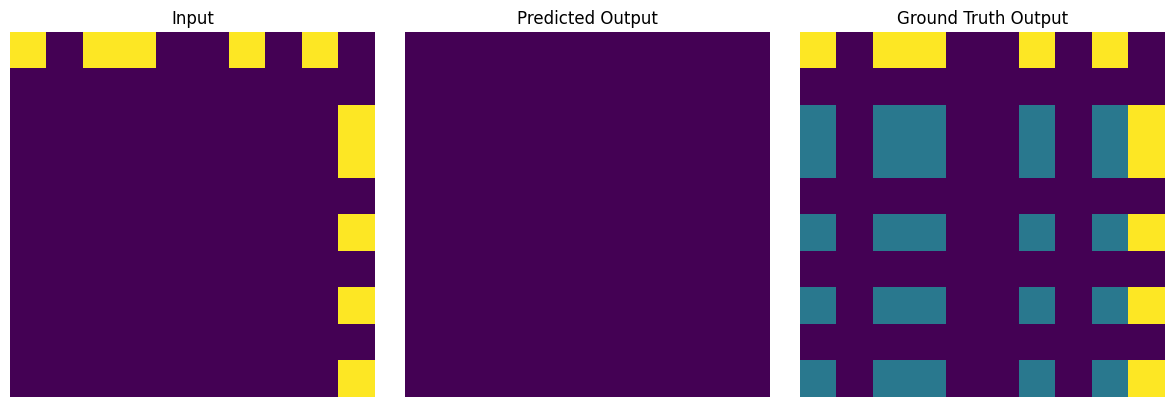

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------- helper --------------------
def safe_transform(grid):
    grid = grid.copy()        # <‑‑ clone so the original stays unchanged
    try:
        return transform(grid)
    except Exception as err:
        print(f"[safe_transform] transform() failed – {err}")
        return np.zeros_like(grid)

# -------------------- test case -----------------
test_case = {
    "input": np.array([  # convert to np.array for convenience
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
    ]),
    "output": np.array([
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5]
    ])
}

# -------------------- run & plot ----------------
predicted_output = safe_transform(test_case["input"])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Input", "Predicted Output", "Ground Truth Output"]
grids  = [test_case["input"], predicted_output, test_case["output"]]

for ax, grid, title in zip(axs, grids, titles):
    im = ax.imshow(grid, cmap="viridis", vmin=0, vmax=5)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [43]:
# Inference testing section ends here

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

You can use this also to load a checkpoint!!! i.e. an intermediate checkpoint from training, so you can then push it to hub.

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [47]:
# TO MANUALLY LOAD A LORA AND THEN MERGE AND PUSH
import os
import unsloth
from unsloth import FastLanguageModel
import torch

checkpoint = 44

if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        # model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        model_name = f"trainer_output/checkpoint-{checkpoint}",
        # max_seq_length = 30000,
        load_in_4bit = False,
    )
    # run_name = "Qwen3-4B_dsarc-programs-50-full-200-partial_20250807-211749"
    # lora_run_name = run_name + f"-c{checkpoint}"
    # print(f"Pushing to Trelis/{lora_run_name}")
    # model = model.merge_and_unload()
    # model.push_to_hub(f"Trelis/{lora_run_name}")
    # tokenizer.push_to_hub(f"Trelis/{lora_run_name}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.9: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA H200. Num GPUs = 1. Max memory: 139.719 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 9.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


In [45]:
# Checkpoint processing based on execution mode
import os, re, torch
from unsloth import FastLanguageModel

# if re-running
# run_name = "Qwen3-Coder-30B-A3B-Instruct_ds-arc-agi-2-mixed-finetuning-20_test"
# execution_mode = "full"
# is_kaggle = False

ROOT = "trainer_output"
RUN_NAME = run_name

if "model" in locals() or "model" in globals():
    del model
if "tokenizer" in locals() or "tokenizer" in globals():
    del tokenizer

try:
    torch.cuda.empty_cache()
except Exception:
    pass

if execution_mode == "final_only":
    print("🔧 Final-only mode: Only processing the last checkpoint")
    
    # Find all checkpoints and get the latest one
    ckpts = []
    for d in os.listdir(ROOT):
        m = re.fullmatch(r"checkpoint-(\d+)", d)
        if m and os.path.isdir(os.path.join(ROOT, d)):
            ckpts.append((int(m.group(1)), os.path.join(ROOT, d)))
    
    if not ckpts:
        print("❌ No checkpoints found!")
    else:
        # Sort and get the last checkpoint
        ckpts.sort(key=lambda x: x[0])
        final_step, final_path = ckpts[-1]
        
        print(f"📦 Processing final checkpoint: {final_step}")
        
        try:
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=final_path,
                load_in_4bit=False,
            )
            
            # Merge and save locally
            merged_model = model.merge_and_unload()
            final_model_path = os.path.join(model_save_dir, f"{RUN_NAME}-final")
            
            print(f"💾 Saving final model to: {final_model_path}")
            merged_model.save_pretrained(final_model_path)
            tokenizer.save_pretrained(final_model_path)
            
            print(f"✅ Final model saved successfully")
            
            # Clean up
            del merged_model, model, tokenizer
            try:
                torch.cuda.empty_cache()
            except Exception:
                pass
                
        except Exception as e:
            print(f"❌ Error processing final checkpoint: {e}")

else:
    print("🔄 Full mode: Processing all checkpoints")
    
    # Original behavior - process all checkpoints
    ckpts = []
    for d in os.listdir(ROOT):
        m = re.fullmatch(r"checkpoint-(\d+)", d)
        if m and os.path.isdir(os.path.join(ROOT, d)):
            ckpts.append((int(m.group(1)), os.path.join(ROOT, d)))
    ckpts.sort(key=lambda x: x[0])  # ascending; use reverse=True for newest first
    
    # 👇 keep only the last 2 checkpoints
    checkpoints_to_push = ckpts[-2:]
    print(f"Found {len(checkpoints_to_push)} checkpoints:", [s for s, _ in checkpoints_to_push])
    
    for step, path in checkpoints_to_push:
        try:
            print(f"\n=== STEP {step} === Loading {path}")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name = path,
                load_in_4bit = False,
                # device_map = "auto",   # uncomment if you have GPU available
            )
            repo_id = f"Trelis/{RUN_NAME}-c{step}"
            
            # if is_kaggle:
            #     # Save locally when running locally
            #     local_path = os.path.join(model_save_dir, f"{RUN_NAME}-c{step}")
            #     if "oss" in local_path:
            #         model.save_pretrained_merged(local_path, tokenizer, save_method = "merged_4bit")
            #         print(f"Saving locally at {local_path} in 4bit")
            #     else:
            #         # merged_model.save_pretrained(local_path)
            #         # tokenizer.save_pretrained(local_path)
            #         model.save_pretrained_merged(local_path, tokenizer, save_method = "merged_16bit")
            #         print(f"Saving locally at {local_path} in 16bit")
            # else:
            #     if "oss" in repo_id:
            #         model.push_to_hub_merged(repo_id, tokenizer, save_method = "merged_4bit")
            #         print(f"Pushing to {repo_id} in 4bit")
            #     else:
            #         #     model = model.merge_and_unload()
            #         #     model.push_to_hub(repo_id,private=True)
            #         #     tokenizer.push_to_hub(repo_id)
            #         model.push_to_hub_merged(repo_id, tokenizer, save_method = "merged_16bit")
            #         print(f"Pushing to {repo_id} in 16bit")
            
            if is_kaggle:
                # Save locally when running locally
                local_path = os.path.join(model_save_dir, f"{RUN_NAME}-c{step}")
                print(f"Saving locally at {local_path}")
                merged_model = model.merge_and_unload()
                merged_model.save_pretrained(local_path)
                tokenizer.save_pretrained(local_path)
                del merged_model
            else:
                print(f"Pushing to {repo_id} …")
                # If you trained with LoRA, keep merge_and_unload(); if full-finetune, drop this line.
                model = model.merge_and_unload()
                model.push_to_hub(repo_id,private=True)
                tokenizer.push_to_hub(repo_id)

            # tidy up between checkpoints
            del model
            del tokenizer
            try:
                torch.cuda.empty_cache()
            except Exception:
                pass

        except Exception as e:
            print(f"[WARN] Skipping checkpoint {step}: {e}")
            
print(f"\n✅ Checkpoint processing complete for {execution_mode} mode")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


🔄 Full mode: Processing all checkpoints
Found 2 checkpoints: [44, 46]

=== STEP 44 === Loading trainer_output/checkpoint-44
==((====))==  Unsloth 2025.8.9: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA H200. Num GPUs = 1. Max memory: 139.719 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 9.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.21s/it]


Pushing to Trelis/Qwen3-4B_ds-rewritten_rLoRA-128-c44 …


100%|██████████| 2/2 [00:29<00:00, 15.00s/it]


Saved model to https://huggingface.co/Trelis/Qwen3-4B_ds-rewritten_rLoRA-128-c44


  0%|          | 0/1 [00:00<?, ?it/s]
tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]
tokenizer.json: 100%|██████████| 11.4M/11.4M [00:04<00:00, 2.63MB/s]
100%|██████████| 1/1 [00:04<00:00,  4.43s/it]
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.



=== STEP 46 === Loading trainer_output/checkpoint-46
==((====))==  Unsloth 2025.8.9: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA H200. Num GPUs = 1. Max memory: 139.719 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 9.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Pushing to Trelis/Qwen3-4B_ds-rewritten_rLoRA-128-c46 …


100%|██████████| 2/2 [00:30<00:00, 15.44s/it]


Saved model to https://huggingface.co/Trelis/Qwen3-4B_ds-rewritten_rLoRA-128-c46


  0%|          | 0/1 [00:00<?, ?it/s]
tokenizer.json: 100%|██████████| 11.4M/11.4M [00:00<00:00, 59.9MB/s]
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



✅ Checkpoint processing complete for full mode


In [46]:
## MANUAL MERGE AFTER THE FACT.
# # pip install -U huggingface_hub transformers peft
# import re, gc, torch
# from huggingface_hub import HfApi
# from transformers import AutoModelForCausalLM, AutoTokenizer
# from peft import PeftModel

# BASE_ID  = "Qwen/Qwen3-4B"
# SRC_REPO = "Trelis/Qwen3-4B_dsarc-programs-50-full-200-incorrect_20250808-134330-trainer"
# REVISION = "main"
# OUT_NS   = "Trelis"
# PRIVATE  = True

# api = HfApi()  # uses HF_TOKEN if set

# def find_checkpoints(repo_id: str, revision: str = "main"):
#     files = api.list_repo_files(repo_id=repo_id, repo_type="model", revision=revision)
#     steps = sorted({int(m.group(1)) for p in files if (m := re.match(r"^checkpoint-(\d+)/", p))})
#     return [f"checkpoint-{s}" for s in steps], files

# def load_tokenizer_for_checkpoint(repo_id: str, subfolder: str):
#     # Try subfolder tokenizer -> repo root tokenizer -> base tokenizer
#     try:
#         return AutoTokenizer.from_pretrained(
#             repo_id, subfolder=subfolder, revision=REVISION, trust_remote_code=True, use_fast=True
#         )
#     except Exception:
#         try:
#             return AutoTokenizer.from_pretrained(
#                 repo_id, revision=REVISION, trust_remote_code=True, use_fast=True
#             )
#         except Exception:
#             return AutoTokenizer.from_pretrained(BASE_ID, trust_remote_code=True, use_fast=True)

# ckpt_dirs, files = find_checkpoints(SRC_REPO, REVISION)
# print("Found checkpoints:", ckpt_dirs)
# if not ckpt_dirs:
#     print("[DEBUG] sample files:", files[:20])

# for sub in ckpt_dirs:
#     step = int(sub.split("-")[1])
#     out_repo = f"{OUT_NS}/{SRC_REPO.split('/',1)[1].replace('-trainer','')}-c{step}"
#     print(f"\n=== {SRC_REPO}/{sub} -> {out_repo} ===")

#     # Load base each time (avoid stacking adapters)
#     base = AutoModelForCausalLM.from_pretrained(
#         BASE_ID, torch_dtype="auto", device_map="auto", trust_remote_code=True, low_cpu_mem_usage=True
#     )

#     # Attach LoRA from checkpoint subfolder
#     peft = PeftModel.from_pretrained(
#         base, model_id=SRC_REPO, subfolder=sub, adapter_name=f"ckpt{step}"
#     )
#     peft.set_adapter(f"ckpt{step}")

#     # Load tokenizer *for this checkpoint*
#     tok = load_tokenizer_for_checkpoint(SRC_REPO, sub)

#     # Optional safety: warn if tokenizer size > embeddings size
#     try:
#         vocab = len(tok)
#         emb = peft.base_model.get_input_embeddings().weight.shape[0]
#         if vocab > emb:
#             print(f"[WARN] tokenizer {vocab} > embeddings {emb} — consider resize or base tokenizer")
#         else:
#             print(f"[OK] tokenizer {vocab} <= embeddings {emb} (padding: {emb - vocab})")
#     except Exception:
#         pass

#     # Bake LoRA into base
#     merged = peft.merge_and_unload()  # returns plain Transformers model

#     # Push baked model + that checkpoint's tokenizer
#     merged.push_to_hub(out_repo, private=PRIVATE)
#     tok.push_to_hub(out_repo)
#     print(f"Pushed {out_repo}")

#     del merged, peft, base, tok
#     gc.collect()
#     try: torch.cuda.empty_cache()
#     except: pass
